In [ ]:
import numpy as np
import matplotlib.pyplot as plt # Collect coords into list
import osm


In [ ]:
# Example
op = osm.Overpass()
buildings = op.getBuildingsFootprints(roi=[49.7955670752582, 9.89987744122153, 49.802298332928636, 9.909039867216649], default_height=5)
# print(buildings[0])
# image_tile = op.getImageTile(lat=49.7955670752582, lon=9.89987744122153, delta_lat=0.005,  delta_long=0.005, zoom=16)
# fig = plt.figure(figsize=(16,16))
# plt.imshow(np.asarray(image_tile))
# plt.show()

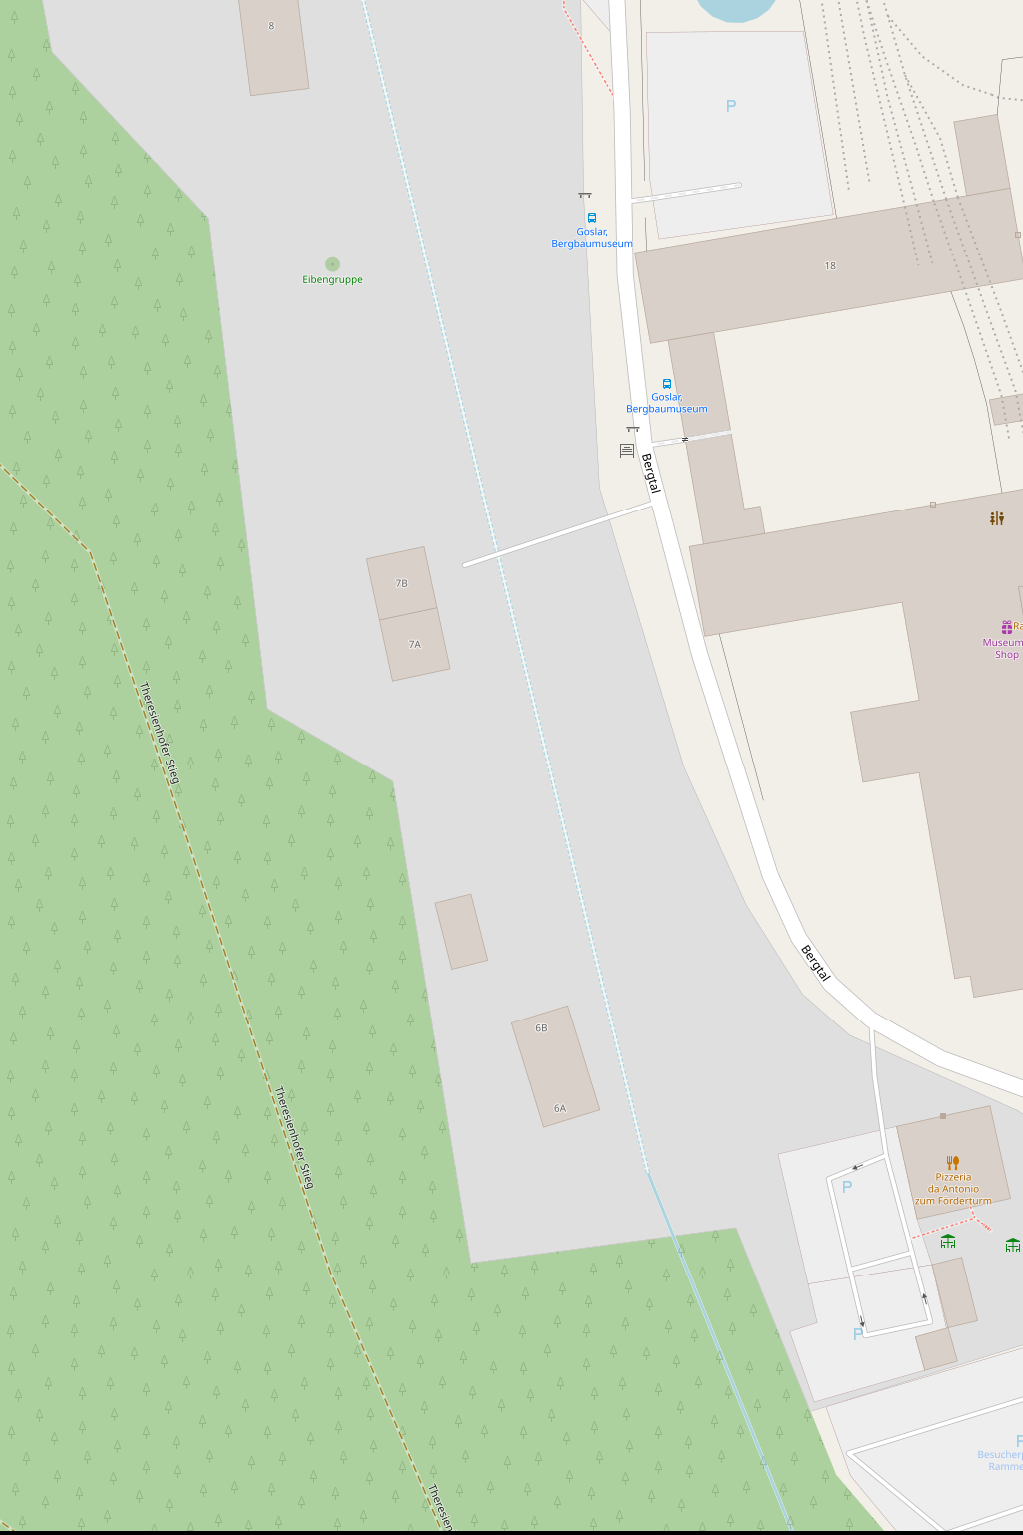

In [14]:
op = osm.Overpass()
pil_image = op.getImageTile(delta_lat=0.002, delta_long=0.002, zoom=19)
pil_image.save('osm_image_tile.jpg')
pil_image


In [ ]:
import osm

# utm = osm.UTM(49.7955670752582, 9.89987744122153, 32, 'U')
# utm.get_utm(49.7955670752582, 9.89987744122153, output_local=True)
# utm.get_latlng(0, 0, local_input=True)
# utm.get_bbox(100)

dem = osm.DEM(roi=(49.7955670752582, 9.89987744122153), size=250)
dem.show_dem2()
# dem.get_altitude(49.7955670752582, 9.89987744122153)
# dem.get_altitudes()

op = osm.Overpass()
buildings, ground, hull = op.getBuildingsFootprints(roi=(49.7955670752582, 9.89987744122153), 
                                                    size=250, 
                                                    default_height=5, 
                                                    upscale_factor=30)


In [ ]:
import utm
lat, lng = 40.749377058452176, -73.98543817164533
lat, lng = 9.7955670752582, 9.89987744122153
lat, lng = 49.801376484175385, 9.934727615561737
lat, lng = 50.10734093879837, 8.664355845621168
print(utm.latitude_to_zone_letter(lat))
print(utm.latlon_to_zone_number(lat, lng))

In [ ]:
# Example
import requests
import json

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="DE"][admin_level=2];
(node["amenity"="biergarten"](area);
 way["amenity"="biergarten"](area);
 rel["amenity"="biergarten"](area);
);
out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()
coords = []
for element in data['elements']:
  if element['type'] == 'node':
    lon = element['lon']
    lat = element['lat']
    coords.append((lon, lat))
  elif 'center' in element:
    lon = element['center']['lon']
    lat = element['center']['lat']
    coords.append((lon, lat))# Convert coordinates into numpy array
X = np.array(coords)
plt.plot(X[:, 0], X[:, 1], 'o')
plt.title(f'Biergarten in Germany: {len(coords)}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

In [ ]:
import os
import types

import cartopy.io.img_tiles as img_tiles
import requests
import PIL


class CachedTiler(object):
    def __init__(self, tiler):
        self.tiler = tiler

    def __getattr__(self, name):
        # Mimic the tiler interface, but for methods, ensure that the "self"
        # that is passed through continues to be CachedTiler, and not the
        # contained tiler instance.
        attr = getattr(self.tiler, name, None)
        if isinstance(attr, types.MethodType):
            attr = types.MethodType(attr.im_func, self)
        return attr

    def get_image(self, tile):
        tileset_name = '{}'.format(self.tiler.__class__.__name__.lower())
        print(tileset_name)
        cache_dir = os.path.expanduser(os.path.join('~/', 'image_tiles', tileset_name))
        if not os.path.exists(cache_dir):
            os.makedirs(cache_dir)
        tile_fname = os.path.join(cache_dir, '_'.join(str(v) for v in tile) + '.png')
        if not os.path.exists(tile_fname):
            response = requests.get(self._image_url(tile),
                                    stream=True)

            with open(tile_fname, "wb") as fh:
                for chunk in response:
                    fh.write(chunk)
        with open(tile_fname, 'rb') as fh:
            img = PIL.Image.open(fh)
            img = img.convert(self.desired_tile_form)     
        return img, self.tileextent(tile), 'lower'
    
from cartopy.io.img_tiles import Stamen
import matplotlib.pyplot as plt


actual_tiler = Stamen()
tiler = CachedTiler(actual_tiler)

mercator = tiler.crs
ax = plt.axes(projection=mercator)
ax.set_extent([-90, -73, 22, 34])
# ax.add_image(tiler, 6)
# ax.coastlines('10m')
# plt.show()

In [ ]:
import osm
import shapely.geometry
points_2d = [(0., 0.), (0., 1.), (1., 1.), (1., 0.),
          (0.5, 0.25), (0.5, 0.75), (0.25, 0.5), (0.75, 0.5)]
points_3d = [
    (0., 0., 0.), (0., 0., 1.), (0., 1., 0.),
    (1., 0., 0.), (1., 1., 0.), (1., 0., 1.),
    (0., 1., 1.), (1., 1., 1.), (.25, .5, .5),
    (.5, .25, .5), (.5, .5, .25), (.75, .5, .5),
    (.5, .75, .5), (.5, .5, .75)
]
pts = []
with open('boundary.txt', 'r') as f:
    for line in f:
        pts.append([float(item) for item in line.rstrip().split(',')])

pg = osm.alpha.alphashape(pts, 1000)
print(pg)
plt.plot(*shapely.geometry.Polygon(pts).exterior.xy)
plt.plot(*pg.exterior.xy)

# print(osm.alpha.alphashape(points_2d, 2))
# osm.alpha.alphashape(points_3d, 2).show()
# osm.alpha.alphashape(points_3d, 2)